# Libraries

In [ ]:
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from tqdm import tqdm
import os
import json
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import shap
import copy
from dataclasses import dataclass
import time
from sklearn.ensemble import IsolationForest
from collections import defaultdict
from timeit import default_timer as timer
#from pysad.models import xStream
from sklearn.preprocessing import StandardScaler
import subprocess


In [ ]:
working_dir = os.getcwd()

import odds_datasets

# Classes and Functions

## Isolation Forest

### Diffi

In [996]:
def local_diffi_vectorized(iforest, X_batch):
    start_time = time.time()
    if len(X_batch.shape) == 1:
        X_batch = X_batch.reshape(1, -1)

    n_samples, n_features = X_batch.shape
    if n_samples == 0:
        return np.empty((0, n_features)), 0.0

    cfi_batch_total = np.zeros((n_samples, n_features), dtype=float)
    counter_batch_total = np.zeros((n_samples, n_features), dtype=float)

    if not iforest.trees:
        return np.zeros((n_samples, n_features)), 0.0

    for tree in iforest.trees:
        if not tree.nodes: 
            continue
        paths_matrix, path_lengths = tree.get_paths_and_path_lengths_vectorized(X_batch)
        
        deltas = np.zeros(n_samples, dtype=float)
        non_zero_len_mask = path_lengths > 0
        
        valid_path_lengths = path_lengths[non_zero_len_mask]
        if valid_path_lengths.size > 0:
             deltas[non_zero_len_mask] = 1.0 / valid_path_lengths

        max_depth_in_batch_for_tree = np.max(path_lengths) if path_lengths.size > 0 else 0
        
        for step in range(max_depth_in_batch_for_tree): 
            features_at_this_step = paths_matrix[:, step]
            
            valid_split_mask = features_at_this_step != -1
            long_enough_path_mask = path_lengths > step # path_lengths is count of splits
            
            final_mask_for_step = valid_split_mask & long_enough_path_mask

            if not np.any(final_mask_for_step):
                continue

            sample_indices_at_step = np.where(final_mask_for_step)[0]
            actual_features_split_on = features_at_this_step[sample_indices_at_step]
            deltas_for_these_samples = deltas[sample_indices_at_step]

            np.add.at(cfi_batch_total, (sample_indices_at_step, actual_features_split_on), deltas_for_these_samples)
            np.add.at(counter_batch_total, (sample_indices_at_step, actual_features_split_on), 1)
            
    fi_batch = np.zeros((n_samples, n_features), dtype=float)
    non_zero_counter_mask = counter_batch_total > 0
    rows, cols = np.where(non_zero_counter_mask)
    if rows.size > 0:
        fi_batch[rows, cols] = cfi_batch_total[rows, cols] / counter_batch_total[rows, cols]
    
    end_time = time.time()
    return fi_batch, end_time - start_time


### ITree

In [997]:
@np.vectorize
def c(n): 
    if n<=1: return 0
    elif n==2: return 1 
    else: return 2*(np.log(n-1)+np.euler_gamma-(n-1)/n)

@dataclass
class Node:
    feature: int = None 
    threshold: float = None
    depth: int = 0 


class RootForcedITree: 
    def __init__(self, max_depth, new_feature=None):
        self.max_depth = max_depth
        self.new_feature = new_feature
        self.nodes = {} 
        self.used_features_in_tree = set() 
        self.features = []

    def _random_split(self, X, force_f = None): 
        if force_f is None: 
            f = np.random.randint(0, X.shape[1])
        else: 
            f = force_f
        
        min_val = np.min(X[:, f])
        max_val = np.max(X[:, f])
        if min_val == max_val: 
            threshold = min_val
        else:
            threshold = np.random.uniform(min_val, max_val)
        return f, threshold
    
    def _build_tree(self, X, depth, node_id): 
        n_samples = X.shape[0]

        if X.shape[0] == 0:
            is_X_all_same = True 
        elif X.shape[0] == 1:
             is_X_all_same = True
        else:
            is_X_all_same = np.all(np.max(X, axis=0) == np.min(X, axis=0))

        if n_samples <= 1 or depth >= self.max_depth or is_X_all_same: 
            leaf_depth = depth + c(n_samples)
            self.nodes[node_id] = Node(feature=None, threshold=None, depth=leaf_depth)
            return
        
        # force feature at root 
        if depth == 0 and self.new_feature is not None: 
            f, threshold = self._random_split(X, self.new_feature)
        else:
            f, threshold = self._random_split(X)
        
        self.used_features_in_tree.add(f)
        self.nodes[node_id] = Node(f, threshold, float(depth)) 
        
        left_mask = X[:, f] <= threshold
        right_mask = ~left_mask 

        left_id, right_id = 2 * node_id + 1, 2 * node_id + 2
        self._build_tree(X[left_mask], depth + 1, left_id)
        self._build_tree(X[right_mask], depth + 1, right_id)

    def fit(self, X): 
        self.nodes = {} 
        self.used_features_in_tree = set() 
        if X.shape[0] == 0 or X.shape[1] == 0: 
            self.nodes[0] = Node(feature=None, threshold=None, depth=c(X.shape[0]))
            self.features = []
            return

        self._build_tree(X, 0, 0)
        self.features = sorted(list(self.used_features_in_tree)) 
    
    def get_depths(self, X): 
        if not self.nodes: 
            return np.zeros(X.shape[0]) + c(0) 

        n_samples = X.shape[0]
        if n_samples == 0:
            return np.array([], dtype=float)
            
        final_paths_depths = np.zeros(n_samples, dtype=float)
        
        current_node_ids = np.zeros(n_samples, dtype=int)
        active_samples_mask = np.ones(n_samples, dtype=bool)
        
        for _iter_count in range(self.max_depth + 2): # Max traversal depth + safety
            if not np.any(active_samples_mask):
                break

            active_indices = np.where(active_samples_mask)[0]
            
            nodes_for_active = [self.nodes[nid] for nid in current_node_ids[active_indices]]
            
            is_leaf_mask_local = np.array([node.feature is None for node in nodes_for_active])
            
            leaf_landed_global_indices = active_indices[is_leaf_mask_local]
            if len(leaf_landed_global_indices) > 0:
                final_paths_depths[leaf_landed_global_indices] = [nodes_for_active[i].depth for i, is_leaf in enumerate(is_leaf_mask_local) if is_leaf]
                active_samples_mask[leaf_landed_global_indices] = False
            
            # Update active_indices for non-leaf samples
            active_indices_for_split = active_indices[~is_leaf_mask_local]
            if len(active_indices_for_split) == 0: 
                break

            nodes_to_split_from = [node for i, node in enumerate(nodes_for_active) if not is_leaf_mask_local[i]]

            split_features = np.array([node.feature for node in nodes_to_split_from], dtype=int)
            split_thresholds = np.array([node.threshold for node in nodes_to_split_from])
            
            X_values_for_split = X[active_indices_for_split, split_features]
            goes_left = X_values_for_split <= split_thresholds
            
            old_node_ids_for_split = current_node_ids[active_indices_for_split]
            
            left_children = 2 * old_node_ids_for_split + 1
            right_children = 2 * old_node_ids_for_split + 2
            
            current_node_ids[active_indices_for_split] = np.where(goes_left, left_children, right_children)
        return final_paths_depths

    def get_paths_and_path_lengths_vectorized(self, X): # For local_diffi
        if not self.nodes:
             return np.full((X.shape[0], self.max_depth), -1, dtype=int), np.zeros(X.shape[0], dtype=int)

        n_samples = X.shape[0]
        if n_samples == 0:
            return np.empty((0, self.max_depth), dtype=int), np.array([], dtype=int)

        paths_features_matrix = np.full((n_samples, self.max_depth), -1, dtype=int)
        path_lengths_actual = np.zeros(n_samples, dtype=int) # Number of splits
        
        current_node_ids = np.zeros(n_samples, dtype=int)
        active_samples_mask = np.ones(n_samples, dtype=bool)
        
        current_traversal_splits = 0 

        while np.any(active_samples_mask) and current_traversal_splits < self.max_depth:
            active_indices = np.where(active_samples_mask)[0]
            
            nodes_for_active = [self.nodes[nid] for nid in current_node_ids[active_indices]]
            is_leaf_mask_local = np.array([node.feature is None for node in nodes_for_active])
            
            leaf_landed_global_indices = active_indices[is_leaf_mask_local]
            if len(leaf_landed_global_indices) > 0:
                active_samples_mask[leaf_landed_global_indices] = False
            
            active_indices_for_split = active_indices[~is_leaf_mask_local]
            if len(active_indices_for_split) == 0:
                break

            nodes_to_split_from = [node for i, node in enumerate(nodes_for_active) if not is_leaf_mask_local[i]]

            split_features = np.array([node.feature for node in nodes_to_split_from], dtype=int)
            split_thresholds = np.array([node.threshold for node in nodes_to_split_from])
            
            paths_features_matrix[active_indices_for_split, current_traversal_splits] = split_features
            path_lengths_actual[active_indices_for_split] += 1

            X_values_for_split = X[active_indices_for_split, split_features]
            goes_left = X_values_for_split <= split_thresholds
            
            old_node_ids_for_split = current_node_ids[active_indices_for_split]
            left_children = 2 * old_node_ids_for_split + 1
            right_children = 2 * old_node_ids_for_split + 2
            current_node_ids[active_indices_for_split] = np.where(goes_left, left_children, right_children)
            
            current_traversal_splits += 1
        
        return paths_features_matrix, path_lengths_actual

### IForest

In [ ]:
class RootForcedIForest: 
    def __init__(self, contamination=0.1, n_estimators=100, max_samples=256, max_depth=8):
        self.contamination = contamination
        self.n_estimators = n_estimators
        self.max_samples = max_samples # This is psi, the subsample size for tree building
        self.max_depth = max_depth
        self.threshold = None
        self.trees = []
    
    def fit(self, X, new_feature=None): 
        n_total_samples = X.shape[0]
        if n_total_samples == 0:
            self.trees = []
            self.threshold = 0.0 
            return self

        current_max_samples_for_subsampling = min(self.max_samples, n_total_samples)
        if current_max_samples_for_subsampling == 0 and n_total_samples > 0:
            current_max_samples_for_subsampling = n_total_samples
        
        self.trees = []
        for _ in range(self.n_estimators): 
            if current_max_samples_for_subsampling == 0 : 
                X_subsample = np.empty((0, X.shape[1]))
            else:
                sampled_indices = np.random.choice(n_total_samples, current_max_samples_for_subsampling, replace=True)
                X_subsample = X[sampled_indices, :]
            
            tree = RootForcedITree(self.max_depth, new_feature)
            tree.fit(X_subsample) # fit handles empty X_subsample internally
            self.trees.append(tree)
        
        training_scores = self.decision_function(X) # Use all X for threshold setting
        self._set_threshold(training_scores)
        return self
    
    def _set_threshold(self, training_scores): 
        if training_scores.size == 0:
            self.threshold = 0.0 
        else:
            self.threshold = np.percentile(training_scores, 100 * (1 - self.contamination))

    def decision_function(self, X, diffi_weights=False):
        n_samples_X = X.shape[0]
        if n_samples_X == 0:
            return np.array([])
            
        if not self.trees:
             return np.ones(n_samples_X) # Max anomaly score if no trees

        depths = np.zeros((n_samples_X, len(self.trees)))
        for i, tree in enumerate(self.trees): 
            depths[:, i] = tree.get_depths(X)

        if diffi_weights and X.shape[1] > 0: # diffi_weights applicable only if features exist
            diffi_scores, _ = local_diffi_vectorized(self, X) 
        
            sum_diffi_per_sample = np.sum(diffi_scores, axis=1, keepdims=True)
            normalized_diffi_scores = np.zeros_like(diffi_scores)
            valid_sum_mask = (sum_diffi_per_sample > 1e-9)[:,0] # Avoid near-zero sums
            if np.any(valid_sum_mask):
                normalized_diffi_scores[valid_sum_mask] = diffi_scores[valid_sum_mask] / sum_diffi_per_sample[valid_sum_mask]

            n_total_features = X.shape[1]
            features_per_tree_mask = np.zeros((len(self.trees), n_total_features), dtype=bool)
            for tree_idx, tree in enumerate(self.trees):
                if tree.features: 
                    features_per_tree_mask[tree_idx, tree.features] = True 
            
            trees_per_feature = np.sum(features_per_tree_mask, axis=0, dtype=float)
            safe_trees_per_feature = np.where(trees_per_feature == 0, 1.0, trees_per_feature)

            partial_diffi_score_per_feature = normalized_diffi_scores / safe_trees_per_feature[np.newaxis, :]
            # Zero out scores for features not used in any tree (where safe_trees_per_feature was 1, original 0)
            partial_diffi_score_per_feature[:, trees_per_feature == 0] = 0.0
            
            weight_per_tree = np.dot(partial_diffi_score_per_feature, features_per_tree_mask.astype(float).T)
            
            sum_weights_per_sample = np.sum(weight_per_tree, axis=1, keepdims=True)
            # Normalize weights to sum to 1 for each sample
            normalized_weight_per_tree = np.zeros_like(weight_per_tree)
            valid_weight_sum_mask = (sum_weights_per_sample > 1e-9)[:,0]
            if np.any(valid_weight_sum_mask):
                 normalized_weight_per_tree[valid_weight_sum_mask] = weight_per_tree[valid_weight_sum_mask] / sum_weights_per_sample[valid_weight_sum_mask]
            else: # If all weights are zero for a sample, use equal weighting for trees for that sample
                 normalized_weight_per_tree = np.full_like(weight_per_tree, 1.0 / len(self.trees) if len(self.trees) > 0 else 0.0)


            avg_depths = np.sum(depths * normalized_weight_per_tree, axis=1)
    
        else: 
            avg_depths = np.mean(depths, axis=1)
        
        if self.max_samples <= 1: # psi <= 1
            c_psi = 0 
        else:
            c_psi = c(self.max_samples)

        if c_psi == 0: 
            # When c_psi is 0 (e.g. self.max_samples=1), scores are 1 if avg_depth is 0, otherwise ambiguous.
            # Typically, path length for a single sample leaf is 0, leading to score 1.
            scores = np.ones_like(avg_depths)
            # If avg_depth > 0 and c_psi = 0, it's an edge case.
            # Score might be 0 (least anomalous) or handled differently.
            # For safety, if depth > 0 it means not immediately isolated.
            scores[avg_depths > 0] = 0.0 # less anomalous if it took some path
            return scores
        else:
            return 2 ** (-avg_depths / c_psi)
    
    def predict(self, X, diffi_weights=False): 
        if self.threshold is None: 
            raise ValueError("Model has not been fitted yet or threshold not set.")
        scores = self.decision_function(X, diffi_weights)
        return (scores >= self.threshold).astype(int) # Corrected: >= threshold for anomaly (consistent with percentile)

    def update(self, teacher, keep_size=False):
        # Make copies to avoid modifying original teacher's trees
        # and to have a distinct list of current trees before modification
        current_own_trees = list(self.trees) # Shallow copy of the list of trees
        new_teacher_trees = copy.deepcopy(teacher.trees)

        if not keep_size:
            # If not keeping size, simply extend with all new trees
            self.trees.extend(new_teacher_trees)
        else:
            # If keeping size, the target is self.n_estimators (original capacity)
            target_n_estimators = self.n_estimators

            # Combine all potential candidate trees (old and new)
            all_candidate_trees = current_own_trees + new_teacher_trees
            num_candidates = len(all_candidate_trees)

            if num_candidates <= target_n_estimators:
                # If the combined pool is within or equal to the target capacity, keep all
                self.trees = all_candidate_trees
            else:
                num_own_trees = len(current_own_trees)
                num_new_trees = len(new_teacher_trees)
                p_own = np.ones(num_own_trees)*num_new_trees
                p_new = np.ones(num_new_trees)*num_own_trees
                p = np.concatenate((p_own, p_new))
                p = p / np.sum(p)
                # If the combined pool exceeds target capacity,
                # uniformly sample target_n_estimators from the combined pool.
                # Each tree (old or new) has an equal chance of being selected.
                chosen_indices = np.random.choice(
                    num_candidates,
                    target_n_estimators,
                    p=p,
                    replace=False  # We want unique trees
                )
                self.trees = [all_candidate_trees[i] for i in chosen_indices]
        
        # Update the actual number of estimators currently in the model
        self.n_estimators = len(self.trees)

        # Update other parameters from teacher
        self.max_samples = max(teacher.max_samples, self.max_samples)
        self.threshold = copy.copy(teacher.threshold)
        self.max_depth = max(teacher.max_depth, self.max_depth)
        self.contamination = copy.copy(teacher.contamination)
        
        return self

In [999]:
def numpy_to_svmlight(X, y=None):
    svmlight_string_data = ""
    for i in range(len(X)):

        if y is not None:
            svmlight_string_data += f"{y[i]} "

        svmlight_string_data += " ".join(
            f"{j}:{feature_value}" 
            for j, feature_value in enumerate(X[i]) if feature_value != 0
        ) + "\n"
    return svmlight_string_data

time_regex = re.compile(r'done in (\d+)ms\nfinal scores of \d+ tuples\.\.\. done in (\d+)ms')
def parse_stderr(stderr_data):
    time_matches = time_regex.findall(stderr_data)
    return int(time_matches[0][0]), int(time_matches[0][1])

In [ ]:
class xStream:
    def __init__(self, exe_path, k=100, c=100, d=15, rowstream=False, nwindows=1, cosine=False):
        self.exe_path = exe_path
        self.k = k
        self.c = c
        self.d = d
        self.rowstream = rowstream
        self.nwindows = nwindows
        self.cosine = cosine

        self.args = [f'--k={self.k}', f'--c={self.c}', f'--d={self.d}', f'--nwindows={self.nwindows}']
        if self.cosine:
            self.args.append('--cosine')
        if self.rowstream:
            self.args.append('--rowstream')

    def fit_score(self, X_train, X_test):

        if isinstance(X_train, np.ndarray):
            n_train = X_train.shape[0]
            input_data_content = numpy_to_svmlight(X_train)
        elif isinstance(X_train, list):
            if len(X_train) == 0 or not all(isinstance(x, np.ndarray) for x in X_train):
                raise ValueError("X_train list must contain numpy arrays.")
            n_train = sum(x.shape[0] for x in X_train)
            input_data_content = "".join(numpy_to_svmlight(x) for x in X_train)
        else:
            raise ValueError("X_train must be either a numpy array or a list of numpy arrays.")
        n_test = X_test.shape[0]
        input_data_content += numpy_to_svmlight(X_test)
        
        process = subprocess.Popen(
                    args=self.args + [f'--initsample={n_train}', f'--scoringbatch={2*(n_test+n_train)}'],
                    executable=self.exe_path,
                    stdin=subprocess.PIPE,  # Tell program to expect input from a pipe
                    stdout=subprocess.PIPE, # Capture program's output
                    stderr=subprocess.PIPE, # Capture program's errors
                    text=True               # For text-based input/output
                )

                # Send the input_data_content to the program's stdin
                # communicate() waits for the process to terminate and returns stdout, stderr
        stdout_data, stderr_data = process.communicate(input=input_data_content)

        if process.returncode == 0:
                res = stdout_data.split()
                n_out = int(res[0])
                if n_out != n_test + n_train:
                    raise RuntimeError(f"xstream output count {n_out} does not match expected {n_test + n_train}.")
                scores = np.array([float(score) for score in res[1:]])
                train_scores = scores[:n_train]
                test_scores = scores[n_train:]
                train_time, test_time = parse_stderr(stderr_data)
                return train_scores, test_scores, train_time, test_time
        else:
            raise RuntimeError(f"xstream failed with exit code {process.returncode}.\nError Output:\n{stderr_data}")

## Dataset slicing sequences

In [ ]:
def incremental_dataset_sizes(n_total, x_min, k):
    """
    Compute dataset increments s_i such that log(cumulative size) grows linearly.

    Args:
        T (int): Number of steps.
        K_final (float): Final total dataset size after T steps.

    Returns:
        list of int: Dataset sizes to add at each step.
    """
    alpha = np.log(n_total) / (k-1)
    i_vals = np.arange(k)
    K_vals = np.exp(alpha * i_vals)
    s_vals = np.diff(K_vals, prepend=0)
    s_vals = np.round(s_vals).astype(int).tolist()
    s_vals[0] = max(x_min, s_vals[0])  # Ensure first dataset has enough points
    s_vals = [max(1, s) for s in s_vals]  # Ensure all increments are at least 1
    return s_vals

In [1003]:
print(sum(incremental_dataset_sizes(1464, 2, 10)))
print(incremental_dataset_sizes(1464, 2, 10))

1466
[2, 1, 3, 6, 14, 32, 72, 161, 362, 813]


## Experiment

In [1004]:
def set_seeds(seed):
    """
    Set random seeds for reproducibility.
    """
    if seed is not None:
        try:
            import os
            os.environ['PYTHONHASHSEED'] = str(seed)
        except:
            pass

        try:
            import random
            random.seed(seed)
        except:
            pass

        try:
            np.random.seed(seed)
        except:
            pass

In [1005]:
# to avoid keyerror in dict[k1][k2]=v if k1 not in dict
def nested_defaultdict():
    return defaultdict(nested_defaultdict)

In [ ]:
def run_isolation_forest_experiment(
    X, y,
    num_experiences,
    num_blocks_per_experience,
    num_test_points,
    n_new_trees,
    xStream_path,
    n_start_trees=100,
    random_state=None,
    feature_permutation=None,
    model_class=None
):
    if model_class is None:
        raise ValueError("You must provide a model class, e.g., RootForcedIsolationForest.")
    
    num_features = X.shape[1]
    
    if num_experiences >= num_features:
        raise ValueError("The number of experiences must be less than the number of features.")

    y_mapped = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(
            X, y_mapped,
            test_size=num_test_points,
            stratify=y_mapped,
            random_state=random_state
        )
    
    # normalize, if xstream needs it
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # baseline 1
    fixed_ap = nested_defaultdict()
    fixed_update_time = nested_defaultdict()
    fixed_inference_time = nested_defaultdict()
    set_seeds(random_state)
    fixed_model = model_class(n_estimators=n_start_trees)

    # baseline 2
    from_scratch_ap = nested_defaultdict()
    from_scratch_update_time = nested_defaultdict()
    from_scratch_inference_time = nested_defaultdict()
    set_seeds(random_state)
    from_scratch_model = model_class(n_estimators=n_start_trees)

    # just to check the seeds setting
    from_scratch_2_ap = nested_defaultdict()
    from_scratch_2_update_time = nested_defaultdict()
    from_scratch_2_inference_time = nested_defaultdict()
    set_seeds(random_state)
    from_scratch_2_model = model_class(n_estimators=n_start_trees)

    # just to check a normal isolation forest
    from_scratch_iso_ap = nested_defaultdict()
    from_scratch_iso_update_time = nested_defaultdict()
    from_scratch_iso_inference_time = nested_defaultdict()
    set_seeds(random_state)
    from_scratch_iso_model = IsolationForest(n_estimators=n_start_trees)

    # cartesian product of:
    # diffi [True, False]
    # keep_size [True, False]
    # force_feature [True, False]

    # base
    ours_none_ap = nested_defaultdict()
    ours_none_update_time = nested_defaultdict()
    ours_none_inference_time = nested_defaultdict()
    set_seeds(random_state)
    ours_none_model = model_class(n_estimators=n_start_trees)

    # base + one new thing
    ours_force_ap = nested_defaultdict()
    ours_force_update_time = nested_defaultdict()
    ours_force_inference_time = nested_defaultdict()
    set_seeds(random_state)
    ours_force_model = model_class(n_estimators=n_start_trees)

    ours_diffi_ap = nested_defaultdict()
    ours_diffi_update_time = nested_defaultdict()
    ours_diffi_inference_time = nested_defaultdict()
    set_seeds(random_state)
    ours_diffi_model = model_class(n_estimators=n_start_trees)

    ours_keepsize_ap = nested_defaultdict()
    ours_keepsize_update_time = nested_defaultdict()
    ours_keepsize_inference_time = nested_defaultdict()
    set_seeds(random_state)
    ours_keepsize_model = model_class(n_estimators=n_start_trees)

    # base + two new things

    ours_force_diffi_ap = nested_defaultdict()
    ours_force_diffi_update_time = nested_defaultdict()
    ours_force_diffi_inference_time = nested_defaultdict()
    set_seeds(random_state)
    ours_force_diffi_model = model_class(n_estimators=n_start_trees)

    ours_keepsize_diffi_ap = nested_defaultdict()
    ours_keepsize_diffi_update_time = nested_defaultdict()
    ours_keepsize_diffi_inference_time = nested_defaultdict()
    set_seeds(random_state)
    ours_keepsize_diffi_model = model_class(n_estimators=n_start_trees)

    ours_force_keepsize_ap = nested_defaultdict()
    ours_force_keepsize_update_time = nested_defaultdict()
    ours_force_keepsize_inference_time = nested_defaultdict()
    set_seeds(random_state)
    ours_force_keepsize_model = model_class(n_estimators=n_start_trees)

    # all together
    ours_all_ap = nested_defaultdict()
    ours_all_update_time = nested_defaultdict()
    ours_all_inference_time = nested_defaultdict()
    set_seeds(random_state)
    ours_all_model = model_class(n_estimators=n_start_trees)

    xstream_ap = nested_defaultdict()
    xstream_update_time = nested_defaultdict()
    xstream_inference_time = nested_defaultdict()
    xstream_prev_train_time = 0
    xstream_model = xStream(xStream_path, k=100, c=100, d=25, rowstream=False, nwindows=0)

    # permutation of the features
    if feature_permutation is not None:
        features_exp = feature_permutation
    else:
        features_exp = np.arange(num_features)
    features_exp = [features_exp[:len(features_exp)-i] for i in reversed(list(range(min(num_features, num_experiences))))]
    
    train_datasets = []
    x_tail = X_train
    y_tail = y_train
    block_samples = incremental_dataset_sizes(x_tail.shape[0], x_min=2, k=num_blocks_per_experience) 
    for i, n_samples in enumerate(block_samples[:-1]): # remove last since it is the last y_tail
        x_tail, x_head, y_tail, y_head = train_test_split(
            x_tail,
            y_tail,
            test_size=n_samples,
            #stratify=y_tail,
            random_state=random_state
        )
        train_datasets.append(x_head)
        if x_tail.shape[0] < block_samples[i+1]:
            # too few samples in the dataset, just cut the blocks_per_experience
            break
    train_datasets.append(x_tail)

    xstream_training = {}  # first experience no training
    for experience, selected_features in enumerate(features_exp):
        
        accumulated_train_dataset = np.empty((0, X_train.shape[1]))
        x_test_exp = X_test[..., selected_features]

        for block in tqdm(range(len(train_datasets)), total=len(train_datasets)):
            accumulated_train_dataset = np.concatenate((accumulated_train_dataset, train_datasets[block]), axis=0)
            block_train_dataset = accumulated_train_dataset[..., selected_features]
            atd_size = accumulated_train_dataset.shape[0]

            # xstream accumulation
            xstream_training[experience] = block_train_dataset

            # from scratch model is refitted every time in any case
            set_seeds(random_state)
            t = timer()
            from_scratch_model.fit(block_train_dataset)
            from_scratch_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            set_seeds(random_state)
            t = timer()
            from_scratch_2_model.fit(block_train_dataset)
            from_scratch_2_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            set_seeds(random_state)
            t = timer()
            from_scratch_iso_model.fit(block_train_dataset)
            from_scratch_iso_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

            # make a copy of the model
            # "for block" is used to assert the influence of the training size, so the model is updated only after the last block"
            exp_ours_none_model = deepcopy(ours_none_model)
            exp_ours_force_model = deepcopy(ours_force_model)
            exp_ours_diffi_model = deepcopy(ours_diffi_model)
            exp_ours_keepsize_model = deepcopy(ours_keepsize_model)
            exp_ours_force_diffi_model = deepcopy(ours_force_diffi_model)
            exp_ours_keepsize_diffi_model = deepcopy(ours_keepsize_diffi_model)
            exp_ours_force_keepsize_model = deepcopy(ours_force_keepsize_model)
            exp_ours_all_model = deepcopy(ours_all_model)

            if experience == 0:
                # the first experience is the same for all models, as there is no previous info and no forced feature
                # and inside of each experience only the training dataset size influence is asserted

                # 8 + fixed 
                set_seeds(random_state)
                t = timer()
                fixed_model.fit(block_train_dataset)
                fixed_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

                set_seeds(random_state)
                t = timer()
                exp_ours_none_model.fit(block_train_dataset)
                ours_none_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

                set_seeds(random_state)
                t = timer()
                exp_ours_force_model.fit(block_train_dataset)
                ours_force_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

                set_seeds(random_state)
                t = timer()
                exp_ours_diffi_model.fit(block_train_dataset)
                ours_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

                set_seeds(random_state)
                t = timer()
                exp_ours_keepsize_model.fit(block_train_dataset)
                ours_keepsize_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

                set_seeds(random_state)
                t = timer()
                exp_ours_force_diffi_model.fit(block_train_dataset)
                ours_force_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

                set_seeds(random_state)
                t = timer()
                exp_ours_keepsize_diffi_model.fit(block_train_dataset)
                ours_keepsize_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

                set_seeds(random_state)
                t = timer()
                exp_ours_force_keepsize_model.fit(block_train_dataset)
                ours_force_keepsize_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

                set_seeds(random_state)
                t = timer()
                exp_ours_all_model.fit(block_train_dataset)
                ours_all_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

            else:
                # fixed model not updated 
                fixed_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = 0
                # 8 ours_models
                # build with n_estimators=n_new_trees, since tmp models are used only to add new trees
                pos_new_feature = block_train_dataset.shape[1]-1

                set_seeds(random_state)
                t = timer()
                tmp_ours_none_model = model_class(n_estimators=n_new_trees)
                ours_none_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
                set_seeds(random_state)
                t = timer()
                tmp_ours_none_model.fit(block_train_dataset)
                ours_none_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t
                set_seeds(random_state)
                t = timer()
                exp_ours_none_model.update(tmp_ours_none_model)
                ours_none_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t
                
                set_seeds(random_state)
                t = timer()
                tmp_ours_force_model = model_class(n_estimators=n_new_trees)
                ours_force_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
                set_seeds(random_state)
                t = timer()
                tmp_ours_force_model.fit(block_train_dataset, new_feature=pos_new_feature)
                ours_force_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t
                set_seeds(random_state)
                t = timer()
                exp_ours_force_model.update(tmp_ours_force_model)
                ours_force_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t

                set_seeds(random_state)
                t = timer()
                tmp_ours_diffi_model = model_class(n_estimators=n_new_trees)
                ours_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
                set_seeds(random_state)
                t = timer()
                tmp_ours_diffi_model.fit(block_train_dataset)
                ours_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t
                set_seeds(random_state)
                t = timer()
                exp_ours_diffi_model.update(tmp_ours_diffi_model)
                ours_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t

                set_seeds(random_state)
                t = timer()
                tmp_ours_keepsize_model = model_class(n_estimators=n_new_trees)
                ours_keepsize_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"]= timer() - t
                set_seeds(random_state)
                t = timer()
                tmp_ours_keepsize_model.fit(block_train_dataset)
                ours_keepsize_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t
                set_seeds(random_state)
                t = timer()
                exp_ours_keepsize_model.update(tmp_ours_keepsize_model, keep_size=True)
                ours_keepsize_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t

                set_seeds(random_state)
                t = timer()
                tmp_ours_force_diffi_model = model_class(n_estimators=n_new_trees)
                ours_force_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
                set_seeds(random_state)
                t = timer()
                tmp_ours_force_diffi_model.fit(block_train_dataset, new_feature=pos_new_feature)
                ours_force_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t
                set_seeds(random_state)
                t = timer()
                exp_ours_force_diffi_model.update(tmp_ours_force_diffi_model)
                ours_force_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t

                set_seeds(random_state)
                t = timer()
                tmp_ours_keepsize_diffi_model = model_class(n_estimators=n_new_trees)
                ours_keepsize_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
                set_seeds(random_state)
                t = timer()
                tmp_ours_keepsize_diffi_model.fit(block_train_dataset)
                ours_keepsize_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t
                set_seeds(random_state)
                t = timer()
                exp_ours_keepsize_diffi_model.update(tmp_ours_keepsize_diffi_model, keep_size=True)
                ours_keepsize_diffi_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t

                set_seeds(random_state)
                t = timer()
                tmp_ours_force_keepsize_model = model_class(n_estimators=n_new_trees)
                ours_force_keepsize_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
                set_seeds(random_state)
                t = timer()
                tmp_ours_force_keepsize_model.fit(block_train_dataset, new_feature=pos_new_feature)
                ours_force_keepsize_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t
                set_seeds(random_state)
                t = timer()
                exp_ours_force_keepsize_model.update(tmp_ours_force_keepsize_model, keep_size=True)
                ours_force_keepsize_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t

                set_seeds(random_state)
                t = timer()
                tmp_ours_all_model = model_class(n_estimators=n_new_trees)
                ours_all_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
                set_seeds(random_state)
                t = timer()
                tmp_ours_all_model.fit(block_train_dataset, new_feature=pos_new_feature)
                ours_all_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t
                set_seeds(random_state)
                t = timer()
                exp_ours_all_model.update(tmp_ours_all_model, keep_size=True)
                ours_all_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] += timer() - t

            if block == len(train_datasets) - 1:
                # update the safe copy of the models
                # 8 ours_models
                ours_none_model = copy.deepcopy(exp_ours_none_model)
                ours_force_model = copy.deepcopy(exp_ours_force_model)
                ours_diffi_model = copy.deepcopy(exp_ours_diffi_model)
                ours_keepsize_model = copy.deepcopy(exp_ours_keepsize_model)
                ours_force_diffi_model = copy.deepcopy(exp_ours_force_diffi_model)
                ours_keepsize_diffi_model = copy.deepcopy(exp_ours_keepsize_diffi_model)
                ours_force_keepsize_model = copy.deepcopy(exp_ours_force_keepsize_model)
                ours_all_model = copy.deepcopy(exp_ours_all_model)
            
            #### TEST
            # 3 from scratch models + fixed + 8 ours_models = 12 models
            # there is no randomness in the test, so we can avoid setting seeds here
            t = timer()
            from_scratch_scores = from_scratch_model.decision_function(x_test_exp)
            from_scratch_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            t = timer()
            from_scratch_model_2_scores = from_scratch_2_model.decision_function(x_test_exp)
            from_scratch_2_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            t = timer()
            iso_scores = -from_scratch_iso_model.decision_function(x_test_exp)
            from_scratch_iso_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            
            t = timer()
            fixed_scores = fixed_model.decision_function(x_test_exp)
            fixed_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

            t = timer()
            ours_none_model_scores = exp_ours_none_model.decision_function(x_test_exp)
            ours_none_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            t = timer()
            ours_force_model_scores = exp_ours_force_model.decision_function(x_test_exp)
            ours_force_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            t = timer()
            ours_diffi_model_scores = exp_ours_diffi_model.decision_function(x_test_exp, diffi_weights=True)
            ours_diffi_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            t = timer()
            ours_keepsize_model_scores = exp_ours_keepsize_model.decision_function(x_test_exp)
            ours_keepsize_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            t = timer()
            ours_force_diffi_model_scores = exp_ours_force_diffi_model.decision_function(x_test_exp, diffi_weights=True)
            ours_force_diffi_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            t = timer()
            ours_keepsize_diffi_model_scores = exp_ours_keepsize_diffi_model.decision_function(x_test_exp, diffi_weights=True)
            ours_keepsize_diffi_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            t = timer()
            ours_force_keepsize_model_scores = exp_ours_force_keepsize_model.decision_function(x_test_exp)
            ours_force_keepsize_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t
            t = timer()
            ours_all_model_scores = exp_ours_all_model.decision_function(x_test_exp, diffi_weights=True)
            ours_all_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = timer() - t

            # Metrics
            from_scratch_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, from_scratch_scores)
            from_scratch_2_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, from_scratch_model_2_scores)
            from_scratch_iso_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, iso_scores)
            fixed_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"]= average_precision_score(y_test, fixed_scores)

            ours_none_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, ours_none_model_scores)
            ours_force_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, ours_force_model_scores)
            ours_diffi_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, ours_diffi_model_scores)
            ours_keepsize_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, ours_keepsize_model_scores)
            ours_force_diffi_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, ours_force_diffi_model_scores)
            ours_keepsize_diffi_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, ours_keepsize_diffi_model_scores)
            ours_force_keepsize_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, ours_force_keepsize_model_scores)
            ours_all_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, ours_all_model_scores)
            ########### xStream

            xstream_keys = sorted(list(xstream_training.keys()))
            _, xstream_scores, xstream_train_time, xstream_test_time = xstream_model.fit_score([xstream_training[k] for k in xstream_keys], x_test_exp)
            xstream_ap[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = average_precision_score(y_test, -xstream_scores)
            xstream_update_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = (xstream_train_time - xstream_prev_train_time) / 1000.0
            xstream_inference_time[f"n_features:{len(selected_features)}"][f"train_set_size:{atd_size}"] = xstream_test_time / 1000.0
            if block == len(train_datasets) - 1:
                #xstream computes from the beginning each time, so we remove the previous end of experience time
                xstream_prev_train_time = xstream_train_time


    main_output = {
        "fixed": {
            "average_precision": fixed_ap,
            "update_time": fixed_update_time,
            "inference_time": fixed_inference_time
        },
        "from_scratch": {
            "average_precision": from_scratch_ap,
            "update_time": from_scratch_update_time,
            "inference_time": from_scratch_inference_time
        },
        "ours_none": {
            "average_precision": ours_none_ap,
            "update_time": ours_none_update_time,
            "inference_time": ours_none_inference_time
        },
        "ours_force": {
            "average_precision": ours_force_ap,
            "update_time": ours_force_update_time,
            "inference_time": ours_force_inference_time
        },
        "ours_diffi": {
            "average_precision": ours_diffi_ap,
            "update_time": ours_diffi_update_time,
            "inference_time": ours_diffi_inference_time
        },
        "ours_keepsize": {
            "average_precision": ours_keepsize_ap,
            "update_time": ours_keepsize_update_time,
            "inference_time": ours_keepsize_inference_time
        },
        "ours_force_diffi": {
            "average_precision": ours_force_diffi_ap,
            "update_time": ours_force_diffi_update_time,
            "inference_time": ours_force_diffi_inference_time
        },
        "ours_keepsize_diffi": {
            "average_precision": ours_keepsize_diffi_ap,
            "update_time": ours_keepsize_diffi_update_time,
            "inference_time": ours_keepsize_diffi_inference_time
        },
        "ours_force_keepsize": {
            "average_precision": ours_force_keepsize_ap,
            "update_time": ours_force_keepsize_update_time,
            "inference_time": ours_force_keepsize_inference_time
        },
        "ours_all": {
            "average_precision": ours_all_ap,
            "update_time": ours_all_update_time,
            "inference_time": ours_all_inference_time
        },
        "xStream": {
            "average_precision": xstream_ap,
            "update_time": xstream_update_time,
            "inference_time": xstream_inference_time
        }
    }

    secondary_output = {
        "from_scratch": deepcopy(main_output["from_scratch"]),
        "from_scratch_2": {
            "average_precision": from_scratch_2_ap,
            "update_time": from_scratch_2_update_time,
            "inference_time": from_scratch_2_inference_time
        },
        "from_scratch_iso": {
            "average_precision": from_scratch_iso_ap,
            "update_time": from_scratch_iso_update_time,
            "inference_time": from_scratch_iso_inference_time
        }
    }

    return main_output, secondary_output


## Function to make plots

In [1007]:
def plot_experiment_results(results, save_dir, dataset_name, model_colors=None, model_lines=None):

    os.makedirs(save_dir, exist_ok=False)  # Create directory if it doesn't exist

    # new_trees -> seeds -> model -> metric -> n_features -> block 

    new_trees_keys = list(results.keys())
    seed_keys = list(results[new_trees_keys[0]].keys())
    models_keys = list(results[new_trees_keys[0]][seed_keys[0]].keys())
    if model_colors is None:
        model_colors = {model: plt.cm.tab10(i) for i, model in enumerate(models_keys)}
    if model_lines is None:
        model_lines = {model: '-' for model in models_keys}
    metrics_keys = list(results[new_trees_keys[0]][seed_keys[0]][models_keys[0]].keys())

    # each new_trees a plot
    for new_trees_k in new_trees_keys:
        n_tree_results = results[new_trees_k]
        # each metric a plot
        for metric in metrics_keys:
            fig_mean, ax_mean = plt.subplots(figsize=(12, 6))
            fig_err, ax_err = plt.subplots(figsize=(12, 6))
            fig_std, ax_std = plt.subplots(figsize=(12, 6))
            # each model a track [concatenate blocks in exp]
            # average all seeds
            n_new_trees = int(new_trees_k.split(':')[1])  # Extract the number of new trees from the key
            title_prefix = f"{dataset_name} - {metric} - {n_new_trees} new trees"
            title_prefix = title_prefix.replace('_', ' ').title()
            x_ticks_labels_exp = None
            x_ticks_labels_blocks = None
            min_n_features = None
            for model in models_keys:
                x = []
                y = []
                for seed in seed_keys:
                    model_results = n_tree_results[seed][model][metric]
                    # Concatenate all blocks for this model and seed
                    x_exp = []
                    y_exp = []
                    if min_n_features is None:
                        min_n_features = min([int(k.split(':')[1]) for k in model_results.keys()])
                    for exp in model_results:
                        block_lengths = list(model_results[exp].keys())
                        x_exp.extend(sorted([int(block.split(':')[1]) for block in block_lengths]))
                        y_exp.extend([model_results[exp][block] for block in block_lengths])
                    x.append(x_exp)
                    y.append(y_exp)

                y = np.array(y)
                if "time" in metric:
                    y = y * 1000  # Convert to milliseconds if it's a time metric
                y_mean = np.mean(y, axis=0)
                # standaerd error for graph, use when the important value is the mean
                # use std if the important part is where the values are
                y_std = np.std(y, axis=0, ddof=1)
                y_ste = y_std / np.sqrt(y.shape[0])
                x = x[0]

                if x_ticks_labels_blocks is None:
                    x_ticks_labels_blocks = [str(v) for v in x]
                if x_ticks_labels_exp is None:
                    x_ticks_labels_exp = []
                    i=min_n_features
                    for val in x:
                        if val == x[0]:
                            x_ticks_labels_exp.append(str(i))
                            i += 1
                        else:
                            x_ticks_labels_exp.append("")
                
                ax_mean.plot(y_mean, label=model, color=model_colors[model], linestyle=model_lines[model])
                ax_err.plot(y_mean, label=model, color=model_colors[model], linestyle=model_lines[model])
                ax_err.fill_between(
                    np.arange(len(y_mean)),
                    y_mean - y_ste,
                    y_mean + y_ste,
                    alpha=0.1,  # transparency for the halo
                    color=model_colors[model]
                )
                ax_std.plot(y_mean, label=model, color=model_colors[model], linestyle=model_lines[model])
                ax_std.fill_between(
                    np.arange(len(y_mean)),
                    y_mean - y_std,
                    y_mean + y_std,
                    alpha=0.1,  # transparency for the halo
                    color=model_colors[model]
                )

            ax_mean.set_xlabel("Training Set Length")
            ax_mean.set_xticks(np.arange(len(y_mean)))
            ax_mean.set_xlim((0, len(y_mean) - 1))
            ax_mean.set_xticklabels(x_ticks_labels_blocks, rotation=45)
            ax_mean.set_ylabel(metric.replace('_', ' ').title() + (" [ms]" if "time" in metric else " [a.u.]"))
            ax_mean.legend(loc='upper left', bbox_to_anchor=(0, 1))
            ax_mean.set_title(title_prefix)
            ax_mean.grid(True, linewidth=0.1)
            # second x axis
            ax_mean_twiny = ax_mean.twiny()     
            ax_mean_twiny.set_xticklabels(x_ticks_labels_exp)
            # allign with the other axis
            ax_mean_twiny.set_xlim(ax_mean.get_xlim())
            ax_mean_twiny.set_xticks(ax_mean.get_xticks())
            ax_mean_twiny.set_xticklabels(x_ticks_labels_exp)
            ax_mean_twiny.tick_params(axis='x', bottom=False, top=True)
            ticks = ax_mean_twiny.xaxis.get_major_ticks()
            for i,tick in enumerate(ticks):
                if x_ticks_labels_exp[i] == "":
                    tick.tick2line.set_visible(False)
                    tick.label2.set_visible(False)
            ax_mean_twiny.set_xlabel("Number of Features")
            fig_mean.savefig(
                os.path.join(save_dir, f"{title_prefix}.pdf"), 
                bbox_inches='tight',
                format='pdf'
            )

            ax_err.set_xlabel("Training Set Length")
            ax_err.set_xticks(np.arange(len(y_mean)))
            ax_err.set_xlim((0, len(y_mean) - 1))
            ax_err.set_xticklabels(x_ticks_labels_blocks, rotation=45)
            ax_err.set_ylabel(metric.replace('_', ' ').title() + (" [ms]" if "time" in metric else " [a.u.]"))
            ax_err.legend(loc='upper left', bbox_to_anchor=(0, 1))
            ax_err.set_title(title_prefix)
            ax_err.grid(True, linewidth=0.1)
            # second x axis
            ax_err_twiny = ax_err.twiny()
            ax_err_twiny.set_xticklabels(x_ticks_labels_exp)
            # allign with the other axis
            ax_err_twiny.set_xlim(ax_err.get_xlim())
            ax_err_twiny.set_xticks(ax_err.get_xticks())
            ax_err_twiny.set_xticklabels(x_ticks_labels_exp)
            ax_err_twiny.tick_params(axis='x', bottom=False, top=True)
            ticks = ax_err_twiny.xaxis.get_major_ticks()
            for i, tick in enumerate(ticks):
                if x_ticks_labels_exp[i] == "":
                    tick.tick2line.set_visible(False)
                    tick.label2.set_visible(False)
            ax_err_twiny.set_xlabel("Number of Features")
            fig_err.savefig(
                os.path.join(save_dir, f"{title_prefix}_err.pdf"),
                bbox_inches='tight',
                format='pdf'
            )

            ax_std.set_xlabel("Training Set Length")
            ax_std.set_xticks(np.arange(len(y_mean)))
            ax_std.set_xlim((0, len(y_mean) - 1))
            ax_std.set_xticklabels(x_ticks_labels_blocks, rotation=45)
            ax_std.set_ylabel(metric.replace('_', ' ').title() + (" [ms]" if "time" in metric else " [a.u.]"))
            ax_std.legend(loc='upper left', bbox_to_anchor=(0, 1))
            ax_std.set_title(title_prefix)
            ax_std.grid(True, linewidth=0.1)
            # second x axis
            ax_std_twiny = ax_std.twiny()
            ax_std_twiny.set_xticklabels(x_ticks_labels_exp)
            # allign with the other axis
            ax_std_twiny.set_xlim(ax_std.get_xlim())
            ax_std_twiny.set_xticks(ax_std.get_xticks())
            ax_std_twiny.set_xticklabels(x_ticks_labels_exp)
            ax_std_twiny.tick_params(axis='x', bottom=False, top=True)
            ticks = ax_std_twiny.xaxis.get_major_ticks()
            for i, tick in enumerate(ticks):
                if x_ticks_labels_exp[i] == "":
                    tick.tick2line.set_visible(False)
                    tick.label2.set_visible(False)
            ax_std_twiny.set_xlabel("Number of Features")
            fig_std.savefig(
                os.path.join(save_dir, f"{title_prefix}_std.pdf"),
                bbox_inches='tight',
                format='pdf'
            )



## Experiment functions

### To check if an Isolation forest would perform well enough in the data

In [1008]:
def isolation_forest_oneshot_AP_check(X,y, test_ratio):
    iforest = IsolationForest(n_estimators=100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_ratio,
        stratify=y
    )
    iforest.fit(X_train)
    scores = - iforest.score_samples(X_test)
    ap = average_precision_score(y_test, scores)
    return ap

### Shap importance rankings

We need to add meaningfull features, it make non sense for the company to purchase/install/integrate a useless sensor

In [1009]:
def shaptree_feature_ranking(X, y, random_states, test_ratio=0.2):
    n_samples, n_features = X.shape
    feature_importance = np.zeros(n_features)
    for seed in tqdm(random_states, total=len(random_states)):
        iforest = IsolationForest(n_estimators=100, random_state=seed)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,  
            test_size=int(n_samples * test_ratio),
            stratify=y,  
            random_state=seed
        )
        # select only anomalies to compute importance
        only_anomalies_test_index = np.where(y_test == 1)[0]
        X_test = X_test[only_anomalies_test_index, ...]

        iforest.fit(X_train)
        explainer = shap.TreeExplainer(iforest)
        shap_values = explainer.shap_values(X_test)
        feature_importance += np.abs(shap_values).mean(axis=0)

    feature_importance /= len(random_states)
    ranking = pd.Series(feature_importance, index=np.arange(n_features)).sort_values(ascending=False)
    return ranking

### General check for rankings

If there are useless features, i.e. the bottom ranking features have very low imporance, then if removing the top-k features should make the performance drop compared to removing the bottom-k ones.

In [1010]:
def test_remove_best_worst_ranking(X, y, ranking, test_ratio, random_states, remove_k, logger):
    n_samples, n_features = X.shape
    if n_features != len(ranking):
        raise ValueError("The number of features in X does not match the length of the ranking.")
    if remove_k > n_features // 2:
        logger (f"remove_k {remove_k} is too large for {n_features} features, setting it to [n_features // 2] {n_features // 2}")
        remove_k = (ranking.shape[0]-1) // 2
    if remove_k < 1:
        logger (f"remove_k {remove_k} is too small, setting it to 1")
        remove_k = 1

    bests = ranking.index[:remove_k]
    worsts = ranking.index[-remove_k:]

    differences = []
    for seed in tqdm(random_states, total=len(random_states)):
        no_best = np.arange(n_features)
        no_best = np.delete(no_best, bests)
        no_worst = np.arange(n_features)
        no_worst = np.delete(no_worst, worsts)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=int(n_samples * test_ratio),
            stratify=y,
            random_state=seed
        )
        
        iforest = IsolationForest(n_estimators=100, random_state=seed)

        iforest.fit(X_train[..., no_best])
        no_best_decision = -iforest.decision_function(X_test[..., no_best])
        no_best_ap = average_precision_score(y_test, no_best_decision)

        iforest.fit(X_train[..., no_worst])
        no_worst_decision = -iforest.decision_function(X_test[..., no_worst])
        no_worst_ap = average_precision_score(y_test, no_worst_decision)

        differences.append(no_worst_ap-no_best_ap)
    return np.mean(differences), np.std(differences)

## Logging function

In [1011]:
def log(message, file=None, verbose=False):
    if verbose:
        print(message)
    if file is not None:
        with open(file, 'a', encoding='utf-8')  as f:
            f.write(message + '\n')

# Experiment

In [ ]:
n_experiences = 3 
n_seeds_exp = 25 
n_blocks_per_experience = 13
n_start_trees = 100
n_trees_progression = [100]
datasets_names = odds_datasets.datasets_names
datasets = [odds_datasets.load(dataset_name=name, scale=False) for name in datasets_names]
test_ratio = 0.2
n_seeds_shap = 30
n_seeds_worst_best = 30
remove_k_worst_best = 2
verbose = False

In [1013]:
# plot of the number of samples and features in each dataset
description_df = pd.DataFrame({
    'Dataset': datasets_names,
    'Samples': [X.shape[0] for X, _ in datasets],
    'Features': [X.shape[1] for X, _ in datasets]
})
description_df.set_index('Dataset', inplace=True)
description_df

,Samples,Features
Dataset,,
wine,129,13
vertebral,240,6
ionosphere,351,33
wbc,378,30
breastw,683,9
pima,768,8
vowels,1456,12
letter,1600,32
cardio,1831,21


In [ ]:
# parameters
dataset_index = 16
xStream_path = None

In [ ]:
current_dataset_key = datasets_names[dataset_index]
results_dir = os.path.join(working_dir, f"results_{current_dataset_key}")

In [1016]:
# make a folder for the results, don't overwrite otherwise it's easy to lose results
if os.path.exists(results_dir):
    raise ValueError(f"Results directory {results_dir} already exists. Please choose a different directory.")
os.makedirs(results_dir, exist_ok=False)

In [ ]:

X, y = datasets[dataset_index]
general_info_file = os.path.join(results_dir, f"{current_dataset_key}_general_info.txt")
main_results_file = os.path.join(results_dir, f"{current_dataset_key}_results.json")
secondary_results_file = os.path.join(results_dir, f"{current_dataset_key}_secondary_results.json")
seeds_file = os.path.join(results_dir, f"{current_dataset_key}_seeds.txt")
main_results = nested_defaultdict()
secondary_results = nested_defaultdict()

log(f"Running experiments for dataset: {current_dataset_key}", file=general_info_file, verbose=verbose)
"""
Log parameters
"""
log("Parameters:", file=general_info_file, verbose=verbose)
log(f"# n_experiences: {n_experiences}", file=general_info_file, verbose=verbose)
log(f"# n_seeds_exp: {n_seeds_exp}", file=general_info_file, verbose=verbose)
log(f"# n_blocks_per_experience: {n_blocks_per_experience}", file=general_info_file, verbose=verbose)
log(f"# n_trees_progression: {n_trees_progression}", file=general_info_file, verbose=verbose)
log(f"# n_start_trees: {n_start_trees}", file=general_info_file, verbose=verbose)
log(f"# test_ratio: {test_ratio}", file=general_info_file, verbose=verbose)
log(f"# n_seeds_shap: {n_seeds_shap}", file=general_info_file, verbose=verbose)
log(f"# n_seeds_worst_best: {n_seeds_worst_best}", file=general_info_file, verbose=verbose)
log(f"# remove_k_worst_best: {remove_k_worst_best}", file=general_info_file, verbose=verbose)


"""
GENERAL DESCRIPRION OF THE DATASET
"""

n_samples, n_features = X.shape
log(f"Number of samples: {n_samples}, Number of features: {n_features}", file=general_info_file, verbose=verbose)
log(f"Original label distribution: {np.unique(y, return_counts=True)}", file=general_info_file, verbose=verbose)

# Try to infer which label is anomaly (usually the minority class)
labels, counts = np.unique(y, return_counts=True)
if len(labels) != 2:
    raise ValueError("Expected a binary classification problem.")
# Assume smaller class is anomaly
anomaly_label = labels[np.argmin(counts)]
# just to avoid problems with "same number of samples in both classes"
normal_label = np.setdiff1d(labels, anomaly_label)[0]  # The other label is normal
# Map: 0 = normal, 1 = anomaly for model compatibility
y_mapped = np.where(y == normal_label, 0, 1)
log(f"Mapped labels: normal={normal_label}→0, anomaly={anomaly_label}→1", file=general_info_file, verbose=verbose)
log(f"Final label distribution: {np.unique(y_mapped, return_counts=True)}", file=general_info_file, verbose=verbose)

"""
CHECK IF THE NUMBER OF FEATURES IS SUFFICIENT FOR THE EXPERIMENTS
If the number of features is less than the number of experiences, reduce the number of experiences.
"""

actual_n_experiences = n_experiences
if n_features < actual_n_experiences:
    log(f"Dataset {current_dataset_key} has too many experiences ({actual_n_experiences}) for {n_features} features.", file=general_info_file, verbose=verbose)
    actual_n_experiences = n_features - 1
    log(f"Reducing number of experiences to n_features - 1: {actual_n_experiences}", file=general_info_file, verbose=verbose)

"""
SHAP TREE FEATURE RANKING AND GENERAL CHECKS
"""

oneshot_if_check_ap = isolation_forest_oneshot_AP_check(X, y_mapped, test_ratio)
log(f"One-shot Isolation Forest AP score: {oneshot_if_check_ap:.4f}", file=general_info_file, verbose=verbose)

ranking_seeds = np.random.randint(0, 10000, n_seeds_shap)
log(f"ranking_seeds: {ranking_seeds.tolist()}", file=seeds_file, verbose=False)
ranking = shaptree_feature_ranking(X, y_mapped, random_states=ranking_seeds, test_ratio=test_ratio)
log(f"Feature ranking based on SHAP values:\n{ranking.to_string(index=True)}", file=general_info_file, verbose=verbose)
feature_order = np.flip(ranking.index)

worst_best_seeds = np.random.randint(0, 10000, n_seeds_worst_best)
log(f"worst_best_seeds: {worst_best_seeds.tolist()}", file=seeds_file, verbose=False)
worst_best_ap_mean, worst_best_ap_std = test_remove_best_worst_ranking(
    X, y_mapped, ranking, test_ratio,
    random_states=worst_best_seeds,
    remove_k=remove_k_worst_best,
    logger=lambda msg: log(msg, file=general_info_file, verbose=verbose)
)
log(
    f"AP difference after removing {remove_k_worst_best} best and worst features: mean={worst_best_ap_mean:.4f}, std={worst_best_ap_std:.4f}",
    file=general_info_file, verbose=verbose
)

experiment_seeds = np.random.randint(0, 10000, n_seeds_exp)
log(f"experiment_seeds: {experiment_seeds.tolist()}", file=seeds_file, verbose=False)

for n_new_trees in n_trees_progression:
    for seed in experiment_seeds:
        log(f"Running experiment with n_new_trees={n_new_trees} and seed={seed}...", file=general_info_file, verbose=verbose)
        main_out, sec_out = run_isolation_forest_experiment(
            X=X,
            y=y_mapped,
            num_experiences=n_experiences,
            num_blocks_per_experience=n_blocks_per_experience,
            n_new_trees=n_new_trees,
            xStream_path=xStream_path,
            feature_permutation=feature_order,
            num_test_points=int(n_samples * test_ratio),
            model_class=RootForcedIForest,
            random_state=seed,
            n_start_trees=n_start_trees
        )
        main_results[f"n_new_trees:{n_new_trees}"][f"seed:{seed}"] = main_out
        secondary_results[f"n_new_trees:{n_new_trees}"][f"seed:{seed}"] = sec_out

with open(main_results_file, 'w') as f:
    json.dump(main_results, f, indent=4)
with open(secondary_results_file, 'w') as f:
    json.dump(secondary_results, f, indent=4)


100%|██████████| 13/13 [15:30<00:00, 71.57s/it]


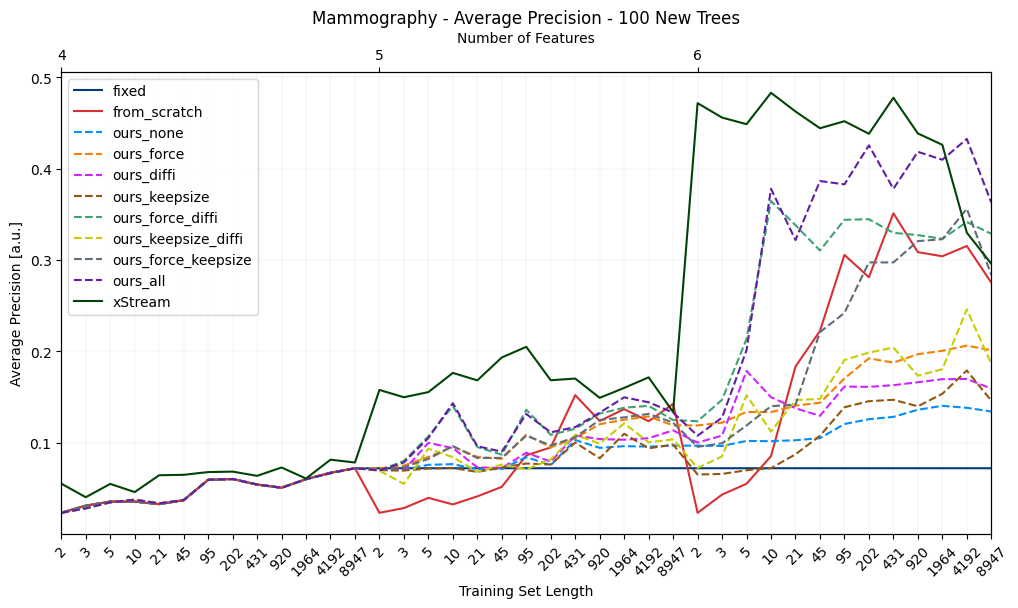

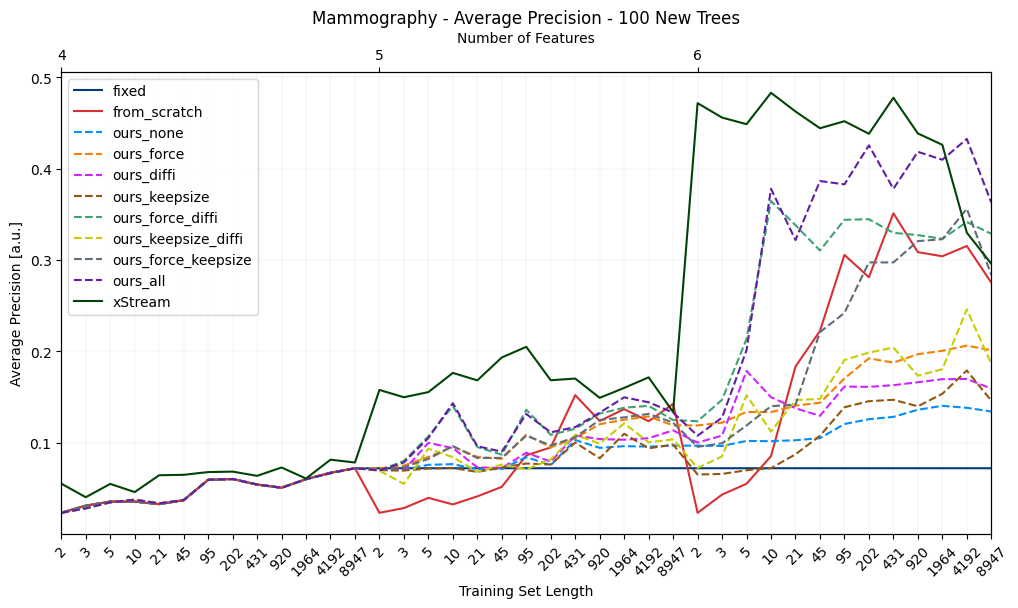

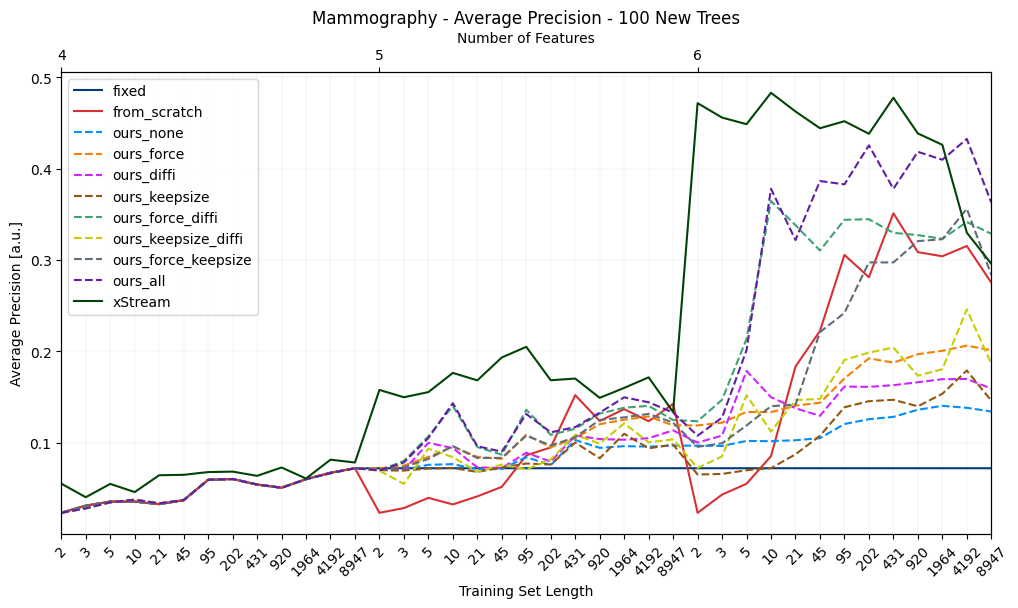

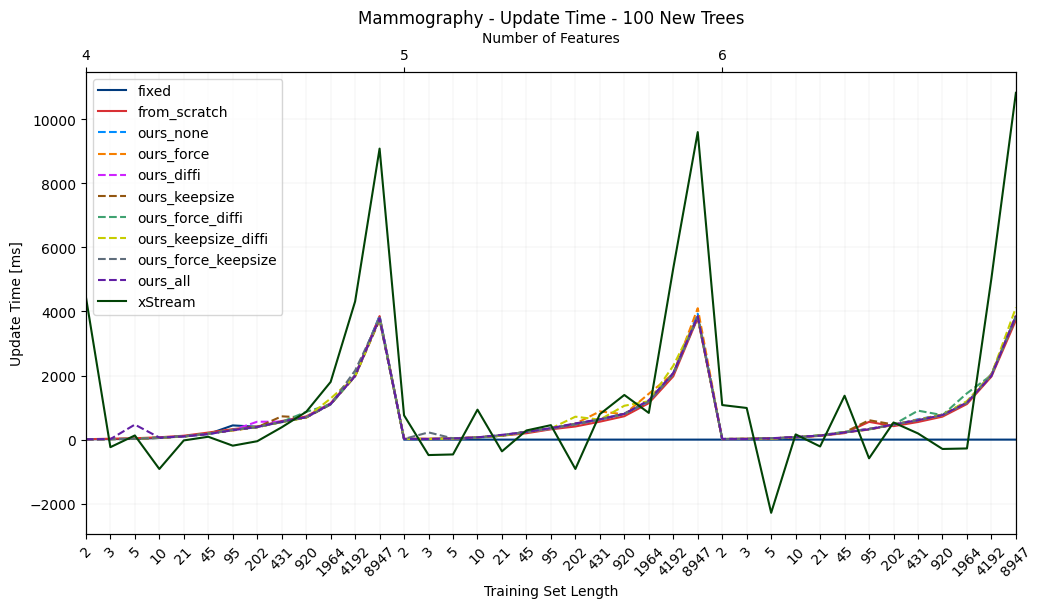

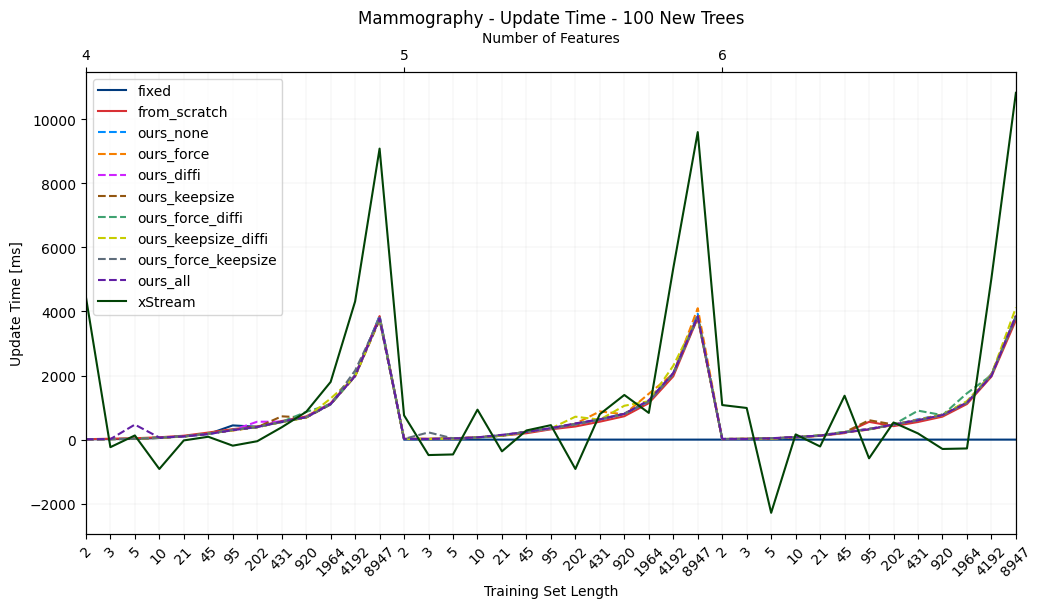

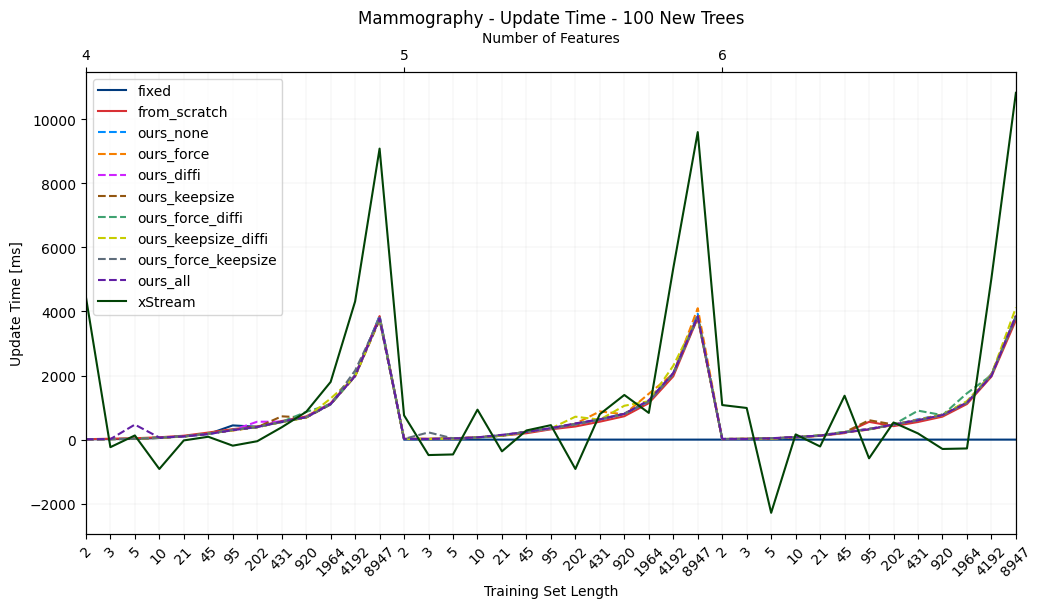

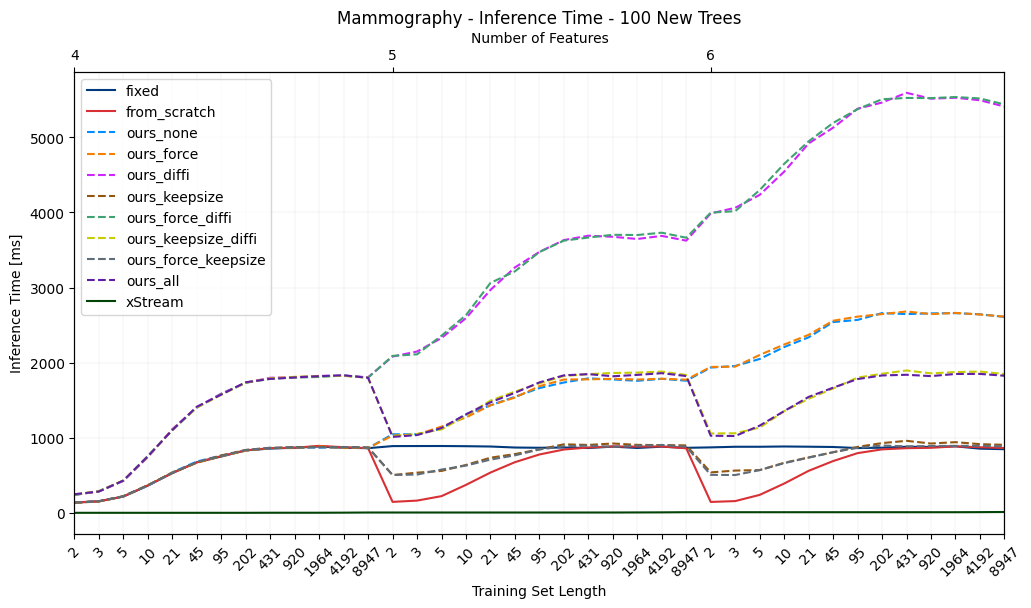

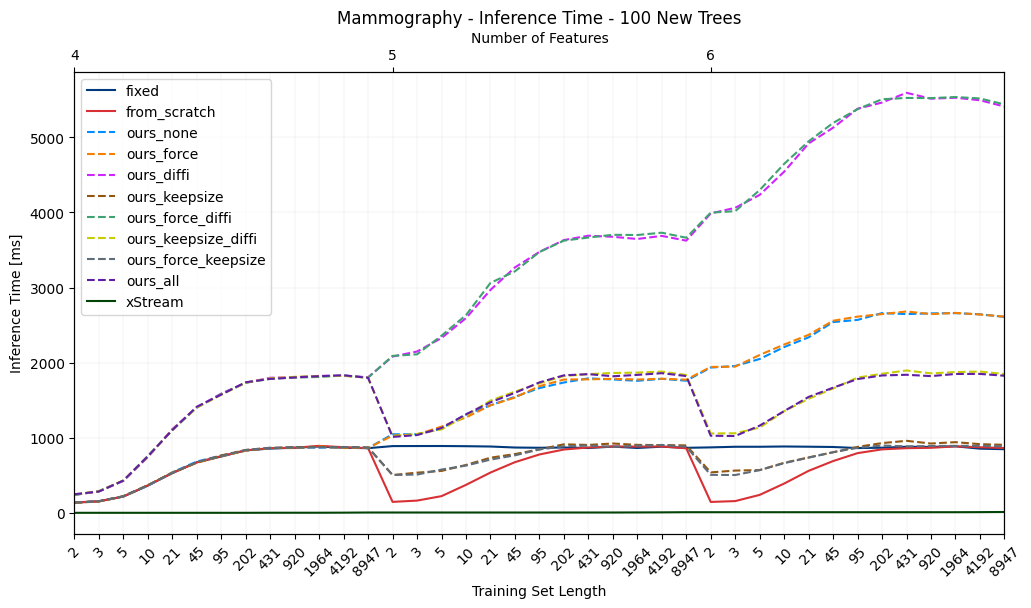

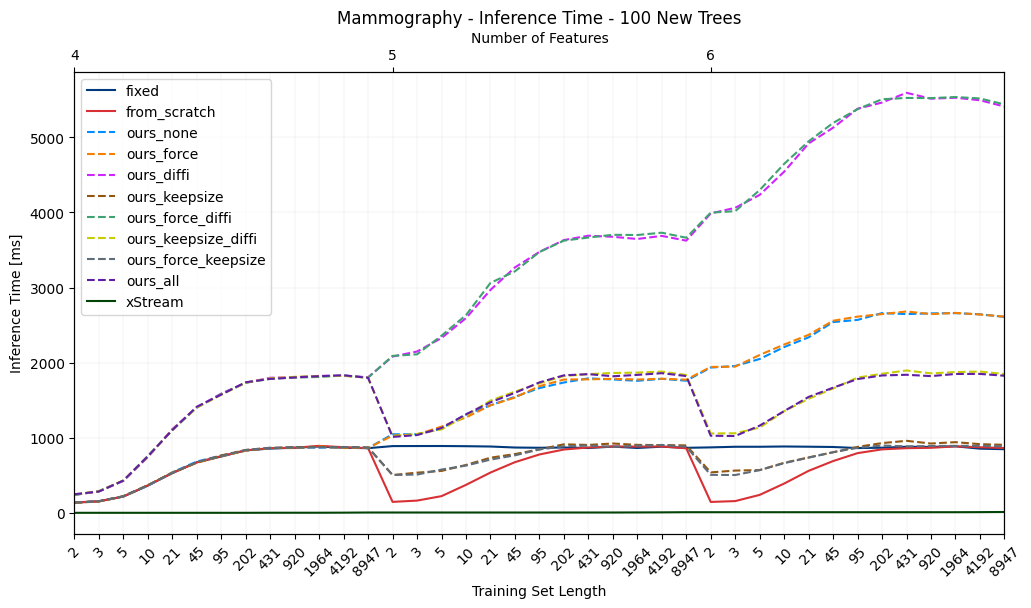

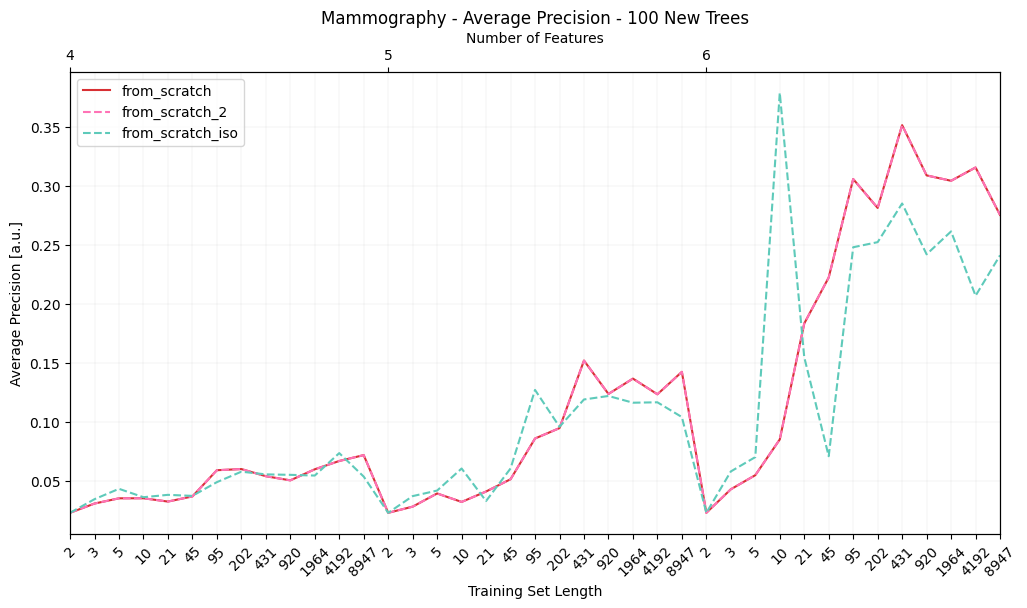

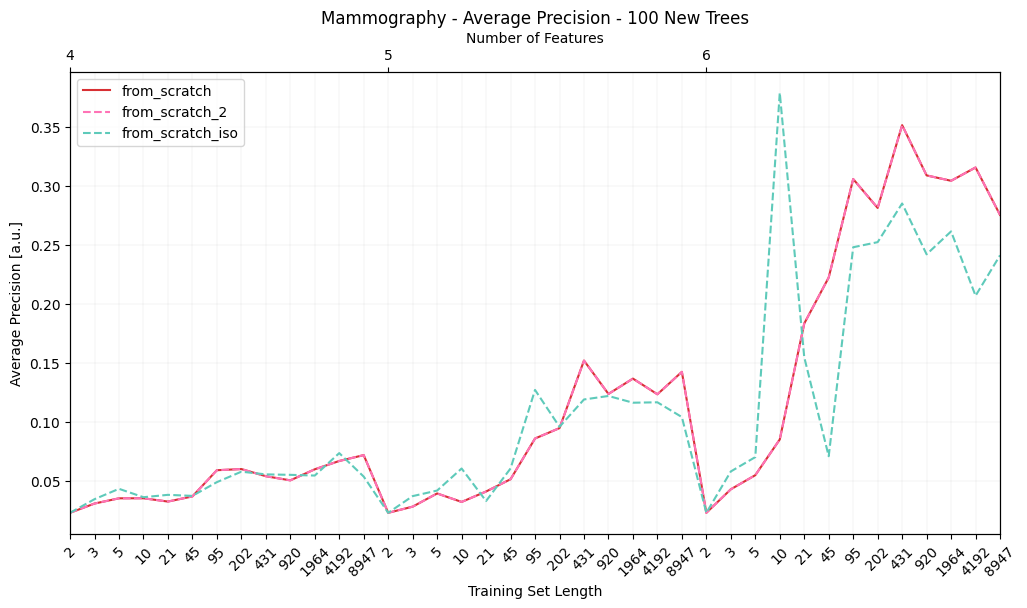

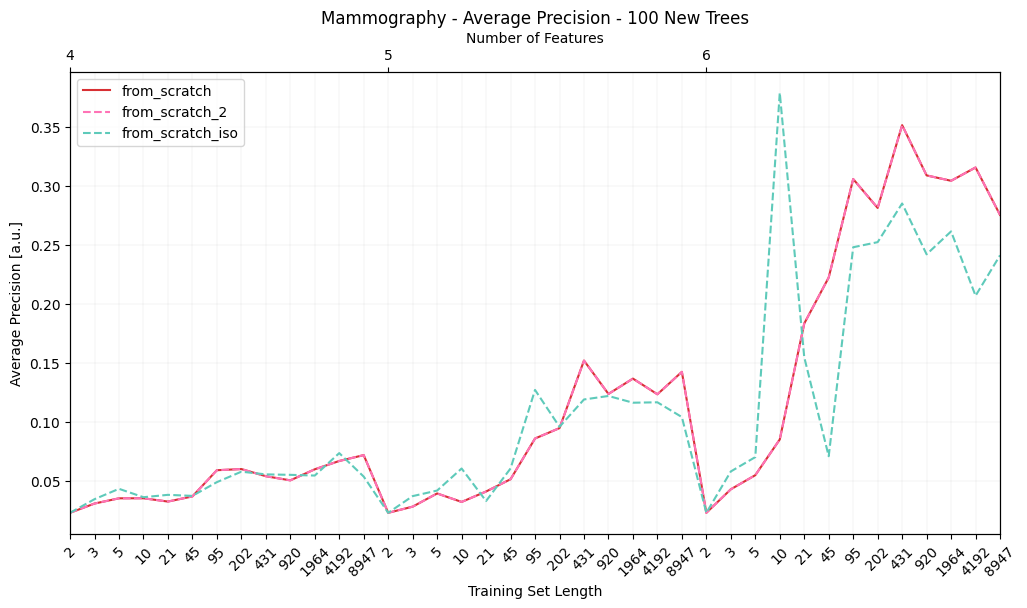

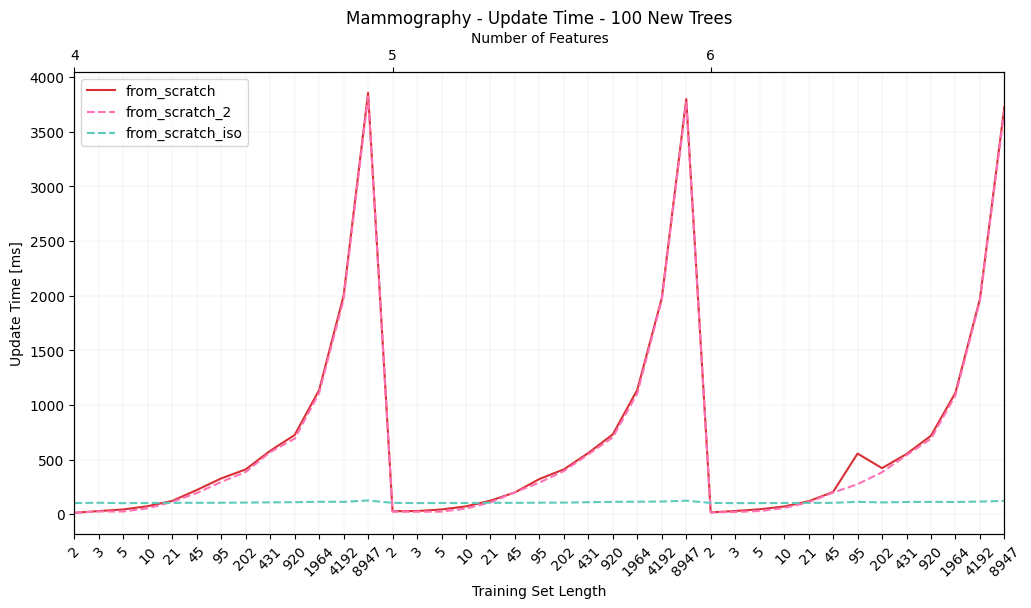

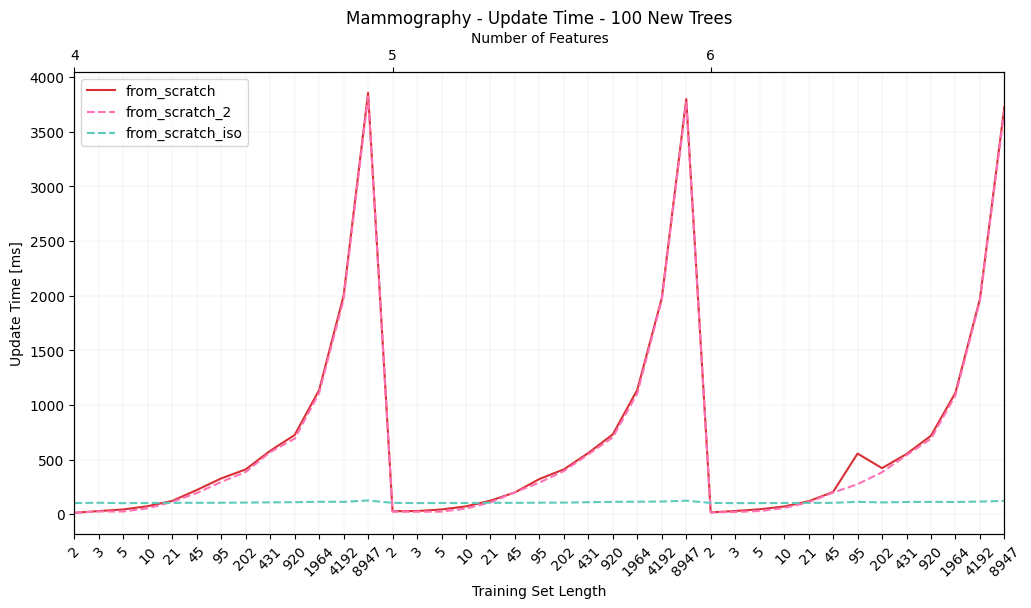

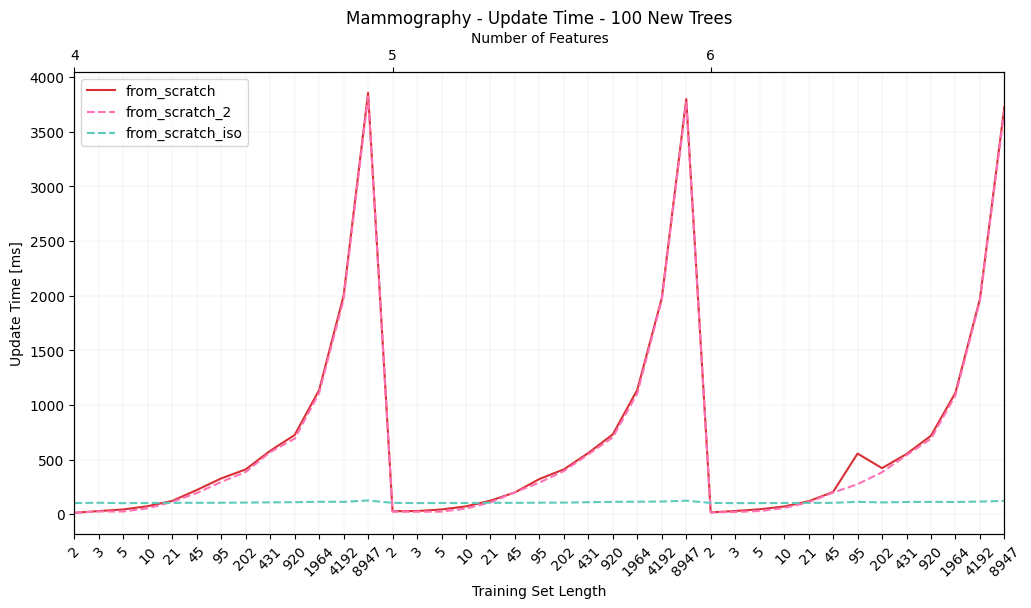

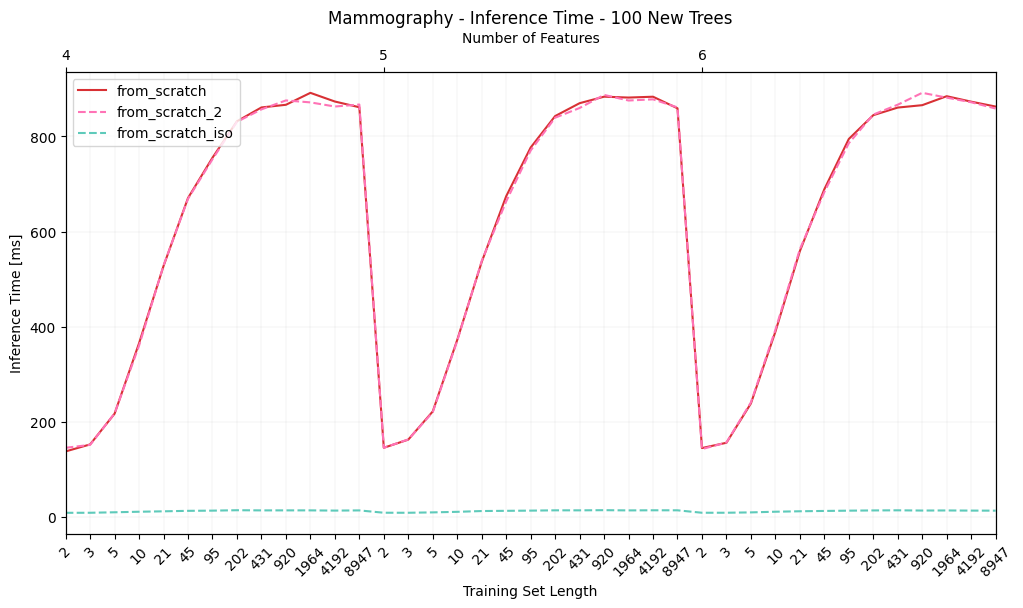

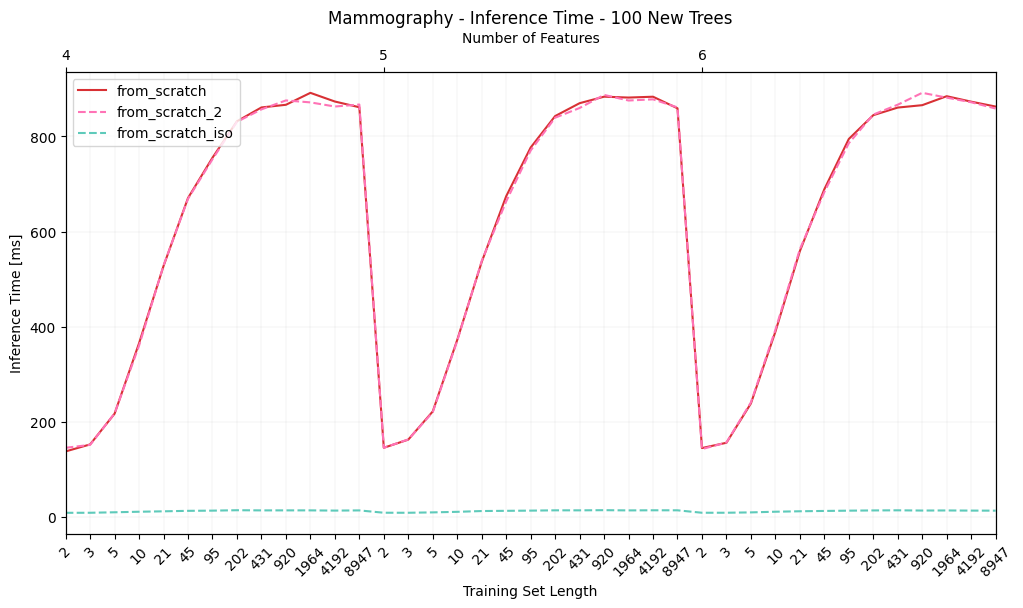

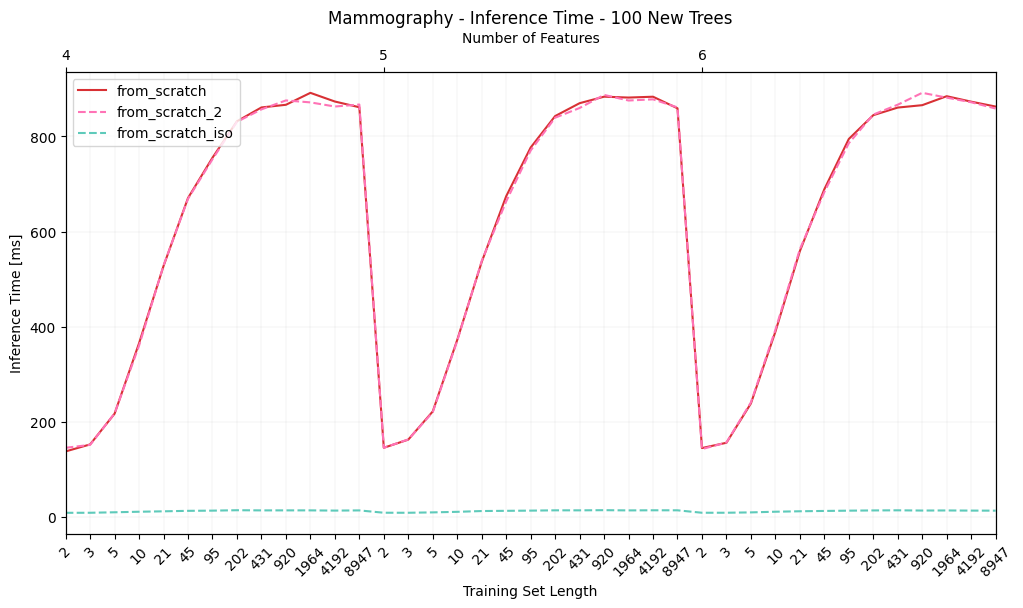

In [1018]:
color_dict = {
    "fixed": "#003a7d",
    "from_scratch": "#d83034",
    "from_scratch_2": "#ff73b6",
    "from_scratch_iso": "#5ecaba",
    "ours_none": "#008dff",
    "ours_force": "#f67f00",
    "ours_diffi": "#cf23ff",
    "ours_keepsize": "#935610",
    "ours_force_diffi": "#3fa271",
    "ours_keepsize_diffi": "#c6cd00",
    "ours_force_keepsize": "#5F6D7B",
    "ours_all": "#611EA4",
    "xStream": "#024306"
    }
lines_dict = {
    "fixed": "-",
    "from_scratch": "-",
    "xStream": "-",
    "from_scratch_2": "--",
    "from_scratch_iso": "--",
    "ours_none": "--",
    "ours_force": "--",
    "ours_diffi": "--",
    "ours_keepsize": "--",
    "ours_force_diffi": "--",
    "ours_keepsize_diffi": "--",
    "ours_force_keepsize": "--",
    "ours_all": "--"
}

plot_folder = os.path.join(results_dir, f"{current_dataset_key}_plots")
secondary_plot_folder = os.path.join(results_dir, f"{current_dataset_key}_secondary_plots")
time_plot_folder = os.path.join(results_dir, f"{current_dataset_key}_time_plots")


main_data = json.load(open(os.path.join(results_dir, f"{current_dataset_key}_results.json"), 'r'))
secondary_data = json.load(open(os.path.join(results_dir, f"{current_dataset_key}_secondary_results.json"), 'r'))
    
plot_experiment_results(
    main_data, 
    save_dir=plot_folder,
    dataset_name=current_dataset_key,
    model_colors=color_dict,
    model_lines=lines_dict
)
plot_experiment_results(
    secondary_data, 
    save_dir=secondary_plot_folder,
    dataset_name=current_dataset_key,
    model_colors=color_dict,
    model_lines=lines_dict
)